# Imports

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import math

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

# Load MV Data

In [142]:
nameFile = 'Cleaned_data_Open_loop_experiment_on_MV_copy.txt'

titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)

if 'MV' in nameFile:
    ExpVariable = 'MV'
    tm = data['tm'].values
    MVm = data['MVm'].values
    PVm = data['PVm'].values    
else:    
    ExpVariable = 'DV'
    tm = data['tm'].values
    DVm = data['DVm'].values 
    PVm = data['PVm'].values
     
print(ExpVariable)

MV


# Parameters optimal FOPDT & SOPDT models

In [143]:
Kp_FOPDTOPT =  0.4576235309466853
T_FOPDTOPT =  120.5570300455653
theta_FOPDTOPT = 27.47774054963327

Kp_SOPDTOPT = 0.45114207269109724
T1_SOPDTOPT = 110.89766441155744
T2_SOPDTOPT = 20.20409707770138
theta_SOPDTOPT = 11.421940328176037

Ts = 1

# Compare step responses (experiment compared with optimal FOPDT & SOPDT)

(0.0, 406.0)

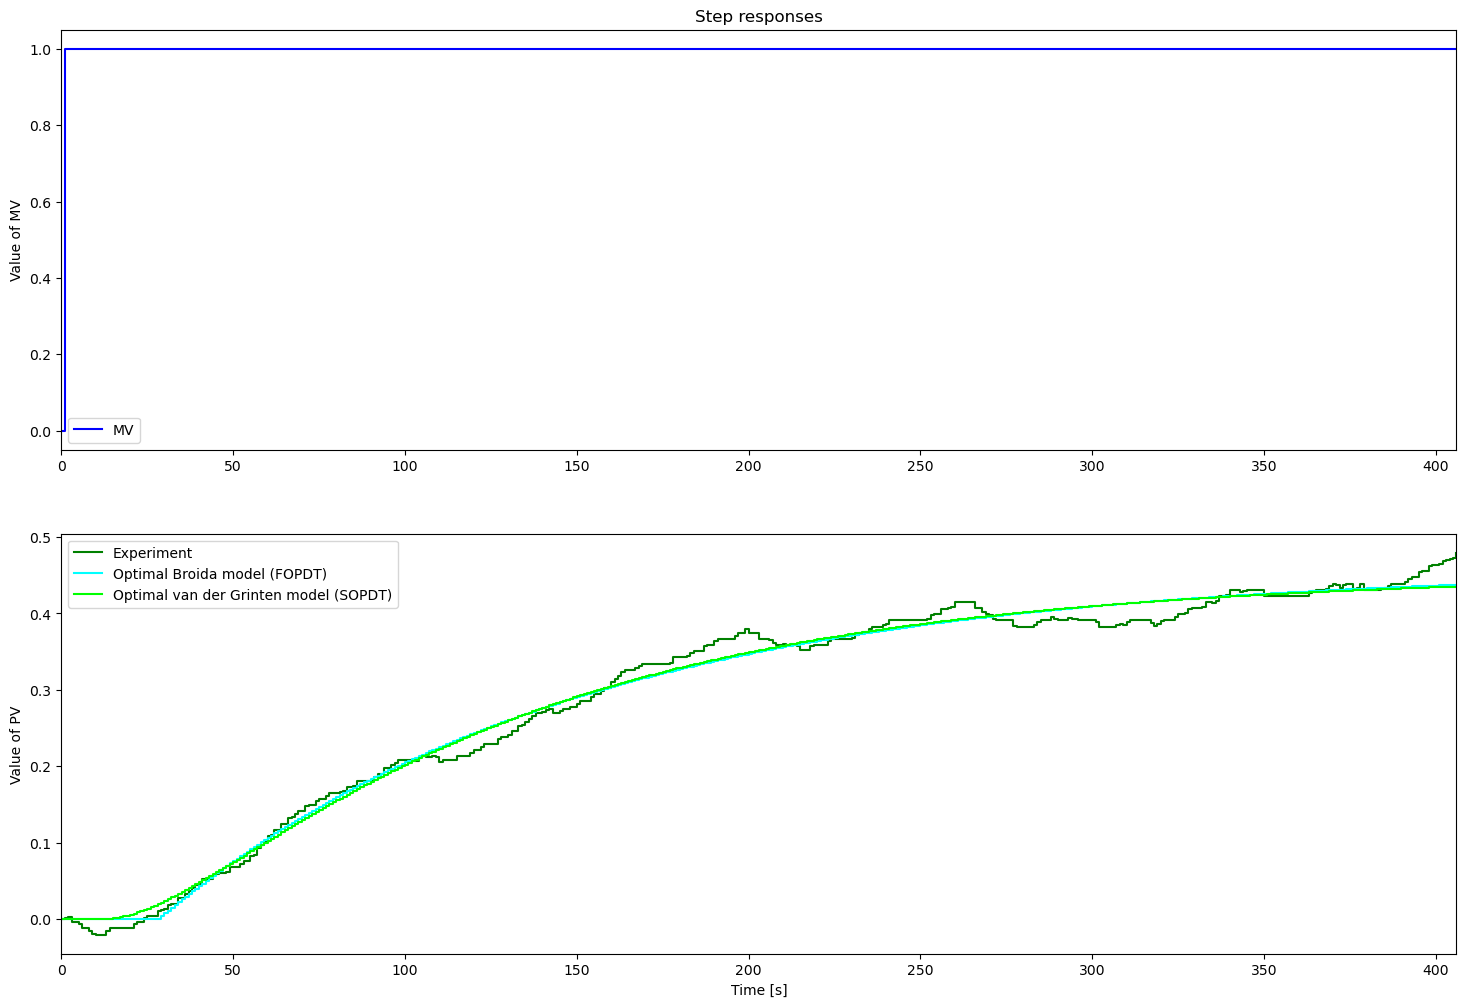

In [144]:
PV_SOPDTOPT = SOPDT(MVm,Kp_SOPDTOPT,T1_SOPDTOPT,T2_SOPDTOPT,theta_SOPDTOPT,Ts)
PV_FOPDTOPT = FOPDT(MVm,Kp_FOPDTOPT,T_FOPDTOPT,theta_FOPDTOPT,Ts)

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
plt.step(tm,MVm,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('Step responses')
plt.legend(loc='best')
plt.xlim([0, np.max(tm)])   

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',label='Experiment',where='post')
plt.step(tm,PV_FOPDTOPT,'cyan',label='Optimal Broida model (FOPDT)',where='post')
plt.step(tm,PV_SOPDTOPT,'lime',label='Optimal van der Grinten model (SOPDT)',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')  
plt.xlim([0, np.max(tm)])

# Compare Bode diagrams (optimal FOPDT & SOPDT)

Text(0, 0.5, 'Phase [°]')

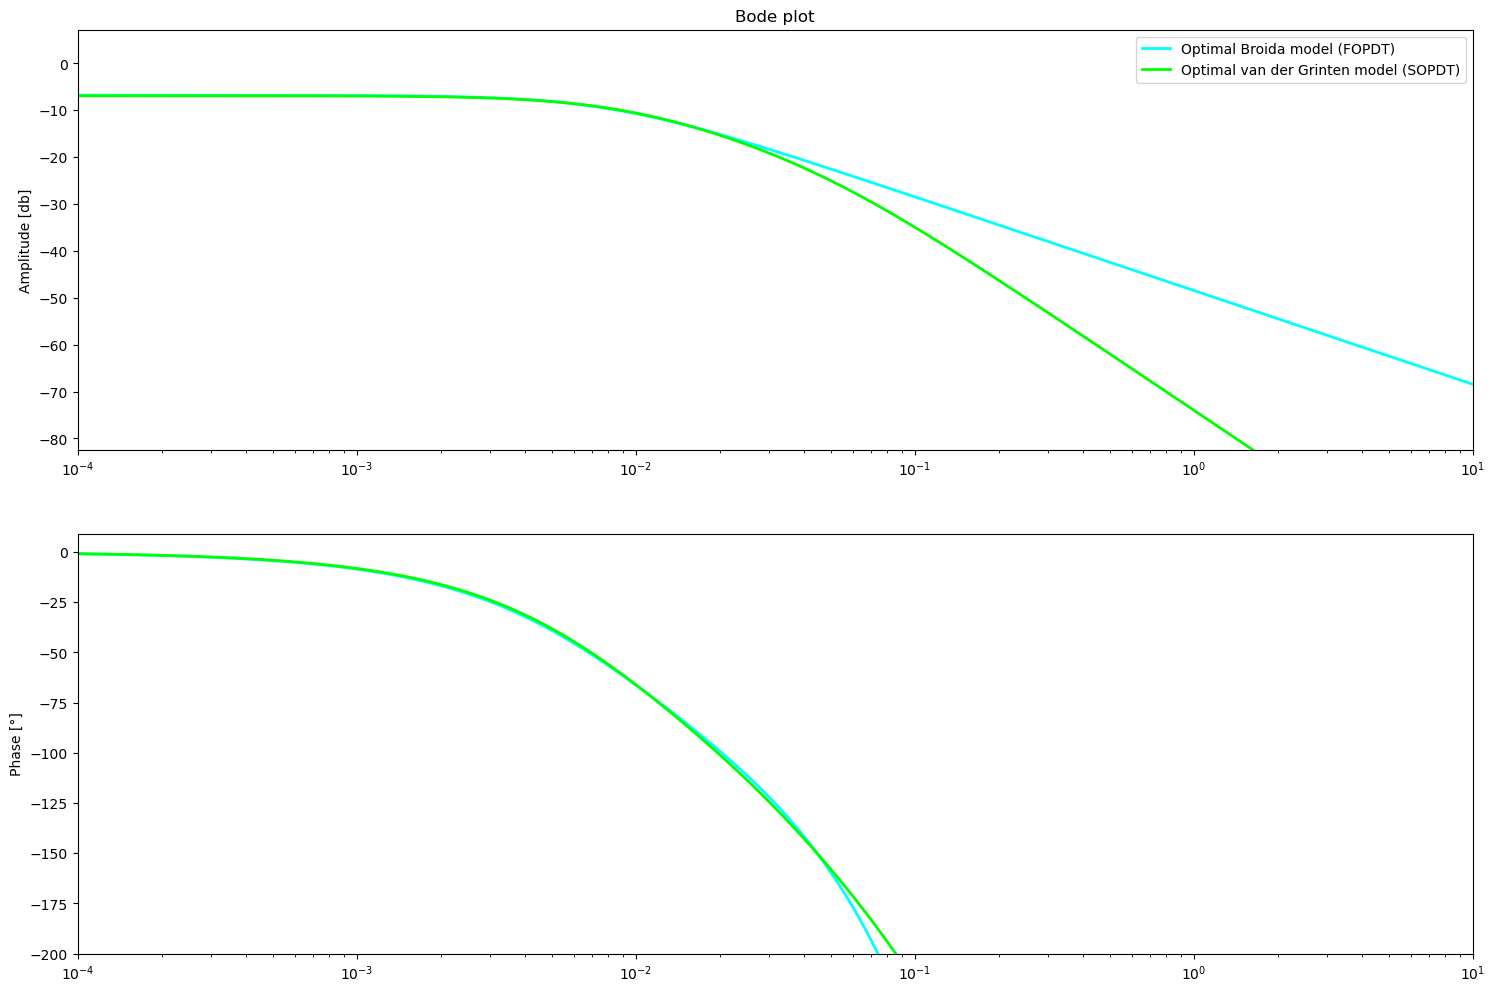

In [145]:
# Frequency response
P_FOPDTOPT = Process({})
P_FOPDTOPT.parameters['Kp'] = Kp_FOPDTOPT
P_FOPDTOPT.parameters['Tlag1'] = T_FOPDTOPT
P_FOPDTOPT.parameters['theta'] = theta_FOPDTOPT

# Frequency response
P_SOPDTOPT = Process({})
P_SOPDTOPT.parameters['Kp'] = Kp_SOPDTOPT
P_SOPDTOPT.parameters['Tlag1'] = T1_SOPDTOPT
P_SOPDTOPT.parameters['Tlag2'] = T2_SOPDTOPT
P_SOPDTOPT.parameters['theta'] = theta_SOPDTOPT

omega = np.logspace(-4, 1, 10000)
Ps_FOPDTOPT = Bode(P_FOPDTOPT,omega,False) # Optimal Broida
Ps_SOPDTOPT = Bode(P_SOPDTOPT,omega,False) # Optimal van der Grinten

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
gain_min = np.min(20*np.log10(np.abs(Ps_FOPDTOPT)/5))
gain_max = np.max(20*np.log10(np.abs(Ps_FOPDTOPT)*5))
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTOPT)),'cyan',linewidth=2,label='Optimal Broida model (FOPDT)')
plt.semilogx(omega,20*np.log10(np.abs(Ps_SOPDTOPT)),'lime',linewidth=2,label='Optimal van der Grinten model (SOPDT)')
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([gain_min, gain_max])
plt.ylabel('Amplitude [db]')
plt.title('Bode plot')
plt.legend(loc='best')

plt.subplot(2,1,2)
ph_min = np.min((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) - 10
ph_max = np.max((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) + 10
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT)),'cyan',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT)),'lime',linewidth=2)
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([np.max([ph_min, -200]), ph_max])
plt.ylabel('Phase [°]')

# Graphical methods

In [146]:
Tsim = 400
Ts = 1
N = 1+int(Tsim/Ts)

alpha = 0.09
Tu = 25
Tg = 160
t1 = 63
t2 = 82
Kp = 0.43
PV_28 = 0.28*Kp
PV_40 = 0.4*Kp

t = []
MV = []


MVPath = {0:0, 1:1, Tsim:1}

for i in range(N):
    t.append(i*Ts)
    SelectPath_RT(MVPath,t,MV)


# Broida 1 (FOPDT)

In [147]:
T_B1 = Tg
theta_B1 = Tu
P_B1 = (Kp*math.exp(-theta_B1)/(Ts + 1))
FOPDT_B1 = FOPDT(MVm, Kp, T_B1, theta_B1, Ts)

# Broida 2 (FOPDT)

In [148]:
T_B2 = 5.5*(t2-t1) 
theta_B2 = (2.8*t1)-(1.8*t2)

P_B2 = (Kp*math.exp(-theta_B2)/(Ts + 1))

FOPDT_B2 = FOPDT(MVm, Kp, T_B2, theta_B2, Ts, 0, P_B2)

# Van der Gritten (SOPDT)

In [149]:
e = math.exp(1)
T1_Vdg = Tg * ((3*alpha*e -1)/(1+alpha*e)) # Valeur négative : modèle invalide
T2_Vdg = Tg * ((1-alpha*e)/(1+alpha*e))
# Nous utiliserons donc t1 et t2 pour déterminer T1 et T2
T1_Vdg = t1
T2_Vdg = t2
theta_Vdg = Tu - (T1_Vdg*T2_Vdg)/(T1_Vdg + 3*T2_Vdg)

P_Vdg = (Kp/((T1_Vdg+1))*(T2_Vdg+1))*math.exp(-theta_Vdg)
SOPDT_Vdg = SOPDT(MVm, Kp, T1_Vdg, T2_Vdg, theta_Vdg, Ts, 0, P_Vdg)

print("T1_Vdg = ", T1_Vdg)
print("T2_Vdg = ", T2_Vdg)
print("theta_Vdg = ", theta_Vdg)


T1_Vdg =  63
T2_Vdg =  82
theta_Vdg =  8.281553398058254


# Strejc (nth order)

In [150]:
if ((Tu/Tg > 0.1) and (Tu/Tg < 0.22)):

    n = 2
    a_n = 0.1
    b_n = 2.72

    T_Strejc = Tg / b_n
    T_uth_Strejc = a_n * Tg
    theta_Strejc = Tu - T_uth_Strejc

    base_Strejc = Ts + 1
    P_Strejc = (Kp*math.exp(-theta_Strejc)/pow(base_Strejc, n))
    SOPDT_Strejc = SOPDT(MVm, Kp, T_Strejc, T_Strejc, theta_Strejc, Ts, 0, P_Strejc)

# Plot all graphical methods

(0.0, 400.0)

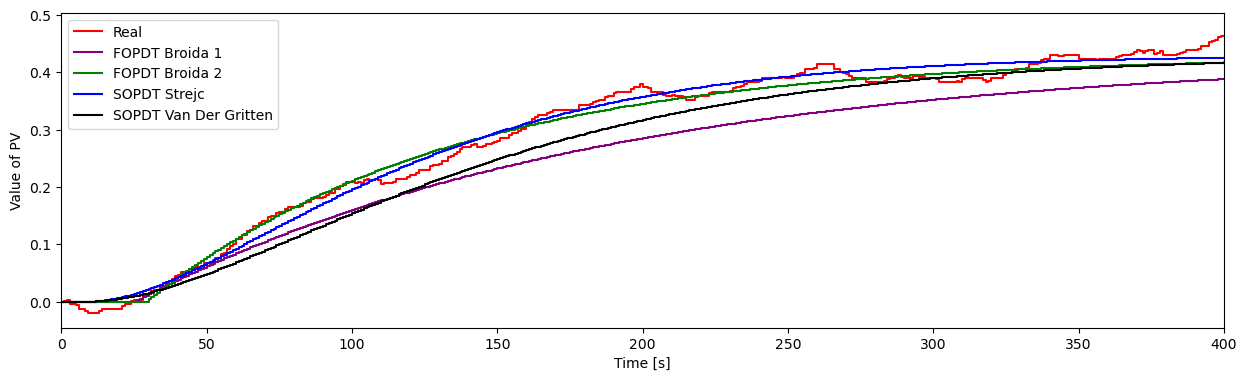

In [151]:
plt.figure(figsize = (15,9))

plt.subplot(2,1,2)
plt.step(tm,PVm,'red',label='Real',where='post')
plt.step(tm,FOPDT_B1,'purple',label='FOPDT Broida 1',where='post')
plt.step(tm,FOPDT_B2,'green',label='FOPDT Broida 2',where='post')
plt.step(tm,SOPDT_Strejc,'blue',label='SOPDT Strejc',where='post')
plt.step(tm,SOPDT_Vdg,'black',label='SOPDT Van Der Gritten',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, Tsim])

# Bode diagram : Graphical methods

In [ ]:
# Frequency response
PROCESS_B1 = Process({})
PROCESS_B1.parameters['Kp'] = Kp
PROCESS_B1.parameters['Tlag1'] = T_B1
PROCESS_B1.parameters['theta'] = theta_B1

# Frequency response
PROCESS_B2 = Process({})
PROCESS_B2.parameters['Kp'] = Kp
PROCESS_B2.parameters['Tlag1'] = T_B2
PROCESS_B2.parameters['theta'] = theta_B2

# Frequency response
PROCESS_VDG = Process({})
PROCESS_VDG.parameters['Kp'] = Kp
PROCESS_VDG.parameters['Tlag1'] = T1_Vdg
PROCESS_VDG.parameters['Tlag2'] = T2_Vdg
PROCESS_VDG.parameters['theta'] = theta_Vdg

# Frequency response
PROCESS_STREJC = Process({})
PROCESS_STREJC.parameters['Kp'] = Kp
PROCESS_STREJC.parameters['Tlag1'] = T_Strejc
PROCESS_STREJC.parameters['Tlag2'] = T_Strejc
PROCESS_STREJC.parameters['theta'] = theta_Strejc

omega = np.logspace(-4, 1, 10000)
Ps_FOPDTOPT = Bode(P_FOPDTOPT,omega,False) # Optimal Broida
Ps_SOPDTOPT = Bode(P_SOPDTOPT,omega,False) # Optimal van der Grinten

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
gain_min = np.min(20*np.log10(np.abs(Ps_FOPDTOPT)/5))
gain_max = np.max(20*np.log10(np.abs(Ps_FOPDTOPT)*5))
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTOPT)),'cyan',linewidth=2,label='Optimal Broida model (FOPDT)')
plt.semilogx(omega,20*np.log10(np.abs(Ps_SOPDTOPT)),'lime',linewidth=2,label='Optimal van der Grinten model (SOPDT)')
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([gain_min, gain_max])
plt.ylabel('Amplitude [db]')
plt.title('Bode plot')
plt.legend(loc='best')

plt.subplot(2,1,2)
ph_min = np.min((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) - 10
ph_max = np.max((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) + 10
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT)),'cyan',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT)),'lime',linewidth=2)
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([np.max([ph_min, -200]), ph_max])
plt.ylabel('Phase [°]')

# Load DV Data

In [152]:
nameFile = 'Cleaned_data_Open_loop_experiment_on_DV_2024-03-19-19h22.txt'

titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)

if 'MV' in nameFile:
    ExpVariable = 'MV'
    tm = data['tm'].values
    MVm = data['MVm'].values
    PVm = data['PVm'].values    
else:    
    ExpVariable = 'DV'
    tm = data['tm'].values
    DVm = data['DVm'].values 
    PVm = data['PVm'].values
     
print(ExpVariable)

DV


# Parameters optimal FOPDT & SOPDT models

In [153]:
Kd_FOPDTOPT = 0.39783787192448916
T_FOPDTOPT =  186.39831116871375
theta_FOPDTOPT = 45.7922546601982

Kd_SOPDTOPT = 0.39493489030424944
T1_SOPDTOPT = 176.54512623159854
T2_SOPDTOPT = 35.063342202231915
theta_SOPDTOPT = 14.280806053306666

Ts = 1

# Compare step responses (experiment compared with optimal FOPDT & SOPDT)

(0.0, 694.0)

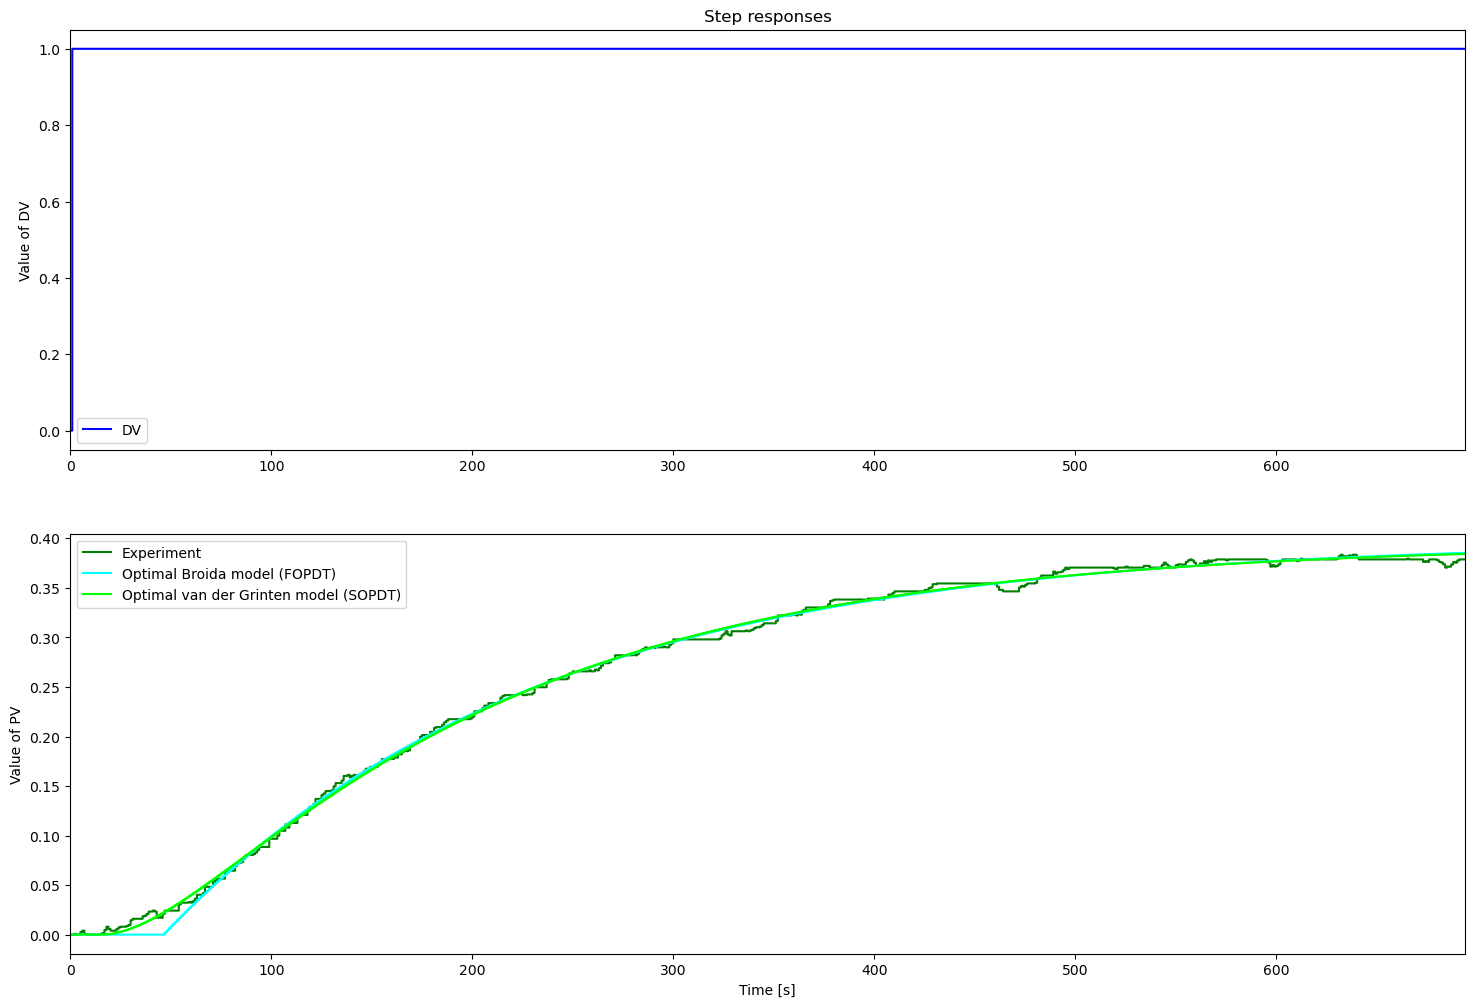

In [154]:
PV_SOPDTOPT = SOPDT(DVm,Kd_SOPDTOPT,T1_SOPDTOPT,T2_SOPDTOPT,theta_SOPDTOPT,Ts)
PV_FOPDTOPT = FOPDT(DVm,Kd_FOPDTOPT,T_FOPDTOPT,theta_FOPDTOPT,Ts)

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
plt.step(tm,DVm,'b-',label='DV',where='post')
plt.ylabel('Value of DV')
plt.title('Step responses')
plt.legend(loc='best')
plt.xlim([0, np.max(tm)])   

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',label='Experiment',where='post')
plt.step(tm,PV_FOPDTOPT,'cyan',label='Optimal Broida model (FOPDT)',where='post')
plt.step(tm,PV_SOPDTOPT,'lime',label='Optimal van der Grinten model (SOPDT)',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')  
plt.xlim([0, np.max(tm)])

# Compare Bode diagrams (optimal FOPDT & SOPDT)

Text(0, 0.5, 'Phase [°]')

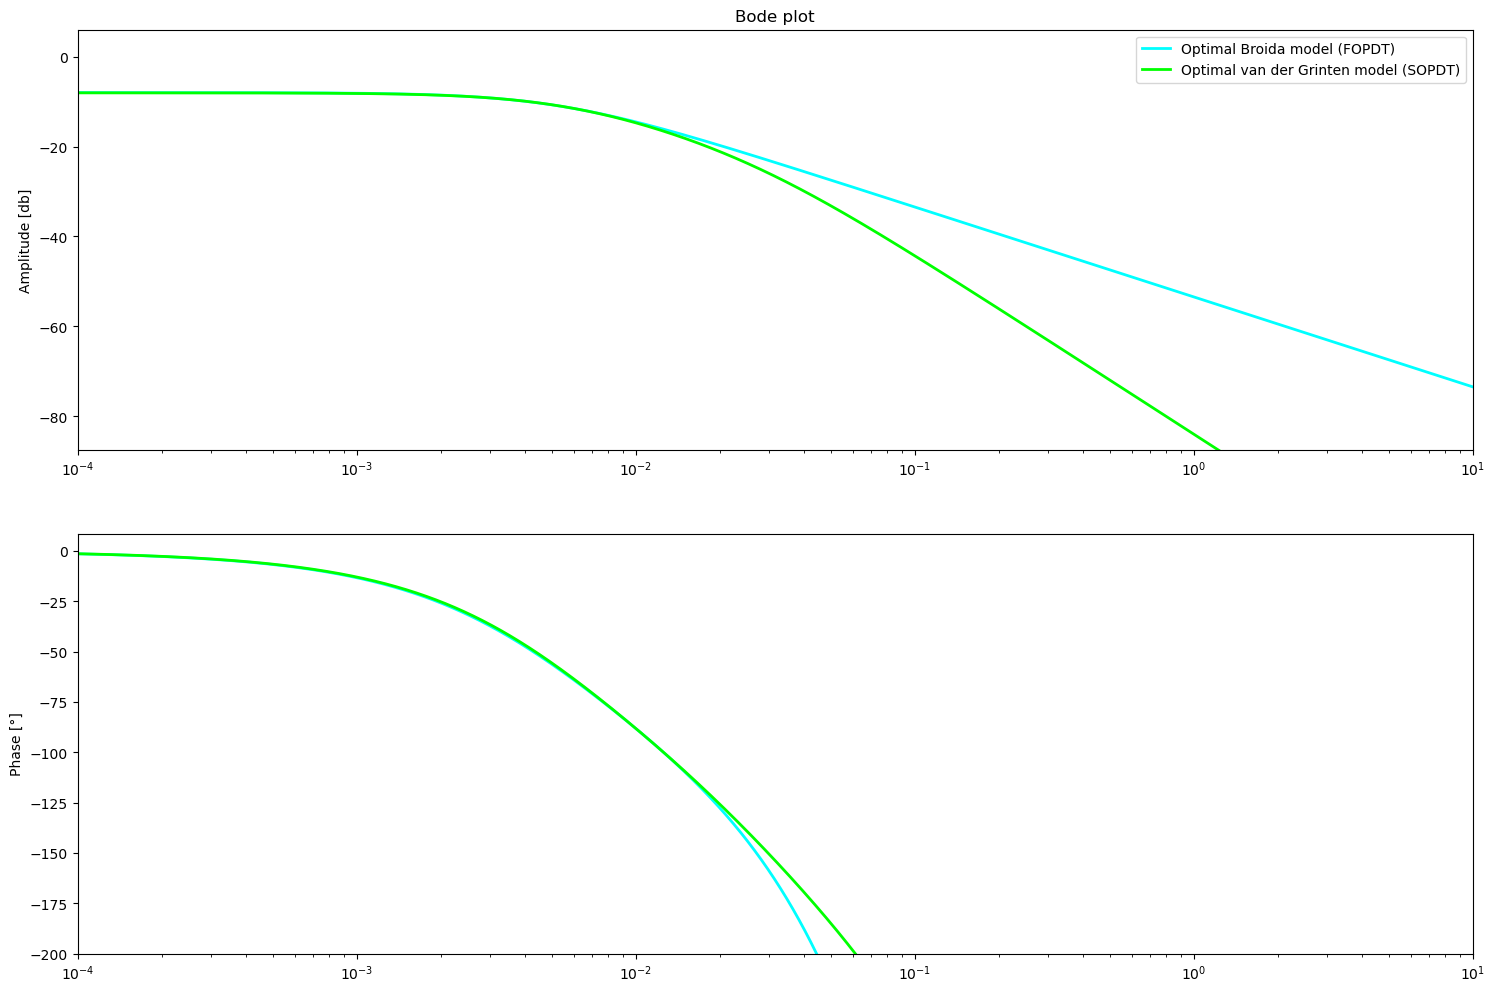

In [155]:
# Frequency response
P_FOPDTOPT = Process({})
P_FOPDTOPT.parameters['Kp'] = Kd_FOPDTOPT
P_FOPDTOPT.parameters['Tlag1'] = T_FOPDTOPT
P_FOPDTOPT.parameters['theta'] = theta_FOPDTOPT

# Frequency response
P_SOPDTOPT = Process({})
P_SOPDTOPT.parameters['Kp'] = Kd_SOPDTOPT
P_SOPDTOPT.parameters['Tlag1'] = T1_SOPDTOPT
P_SOPDTOPT.parameters['Tlag2'] = T2_SOPDTOPT
P_SOPDTOPT.parameters['theta'] = theta_SOPDTOPT

omega = np.logspace(-4, 1, 10000)
Ps_FOPDTOPT = Bode(P_FOPDTOPT,omega,False) # Optimal Broida
Ps_SOPDTOPT = Bode(P_SOPDTOPT,omega,False) # Optimal van der Grinten

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
gain_min = np.min(20*np.log10(np.abs(Ps_FOPDTOPT)/5))
gain_max = np.max(20*np.log10(np.abs(Ps_FOPDTOPT)*5))
plt.semilogx(omega,20*np.log10(np.abs(Ps_FOPDTOPT)),'cyan',linewidth=2,label='Optimal Broida model (FOPDT)')
plt.semilogx(omega,20*np.log10(np.abs(Ps_SOPDTOPT)),'lime',linewidth=2,label='Optimal van der Grinten model (SOPDT)')
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([gain_min, gain_max])
plt.ylabel('Amplitude [db]')
plt.title('Bode plot')
plt.legend(loc='best')

plt.subplot(2,1,2)
ph_min = np.min((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) - 10
ph_max = np.max((180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT))) + 10
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_FOPDTOPT)),'cyan',linewidth=2)
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT)),'lime',linewidth=2)
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([np.max([ph_min, -200]), ph_max])
plt.ylabel('Phase [°]')